how does zonal, meridional and vertical advection deviate from climatology for afternoon precipitation events?

- resolution of ERA5: 0.25 degree

In [31]:
import numpy as np
import os
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as mcolors
import dask.array as da
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [902]:
# lives in gpm_precip, where i found all dates that qualify as an afternoon precipitation event over the SGP domain 

with open("ape_df.pkl", "rb") as f:  
        
    ape_df = pickle.load(f)

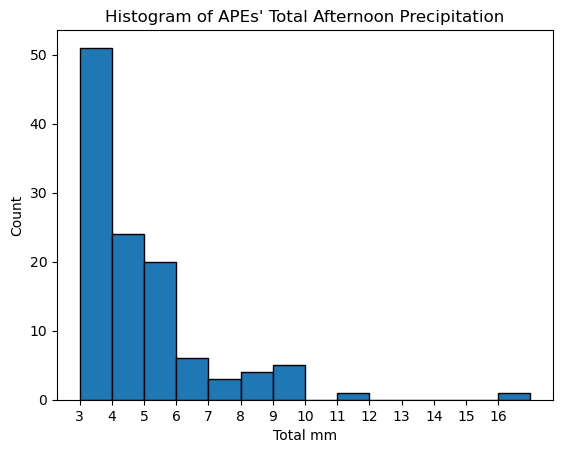

In [852]:
# Determine the range of your data

x_min = int(ape_df['total_afternoon_precip'].min())

x_max = int(ape_df['total_afternoon_precip'].max())

# Use bins that align with integers
bins = np.arange(x_min, x_max + 2)  # +2 to include the last integer as a separate bin

# Plot the histogram
plt.hist(ape_df['total_afternoon_precip'], bins=bins, edgecolor='black')
plt.ylabel("Count")
plt.title("Histogram of APEs' Total Afternoon Precipitation")
plt.xlabel("Total mm")

# Set x-ticks at every integer
plt.xticks(np.arange(x_min, x_max + 1, 1))

plt.show()

In [329]:
# reading in ERA5 to compare

base_path = '/data/rong4/Data/ERA5/3hourly/quvw_US'

# Define the range of years and months
years = [str(year) for year in range(1979, 2020)]

def get_files(folder, component):

    files = glob.glob(os.path.join(base_path, folder, f"era5.{component}.*.nc"))

    filtered_files = [f for f in files if any(year in f for year in years)]
    
    return filtered_files

# Get the files for each component

u_files = get_files('u_component_of_wind', 'u_component_of_wind')

v_files = get_files('v_component_of_wind', 'v_component_of_wind')

w_files = get_files('vertical_velocity', 'vertical_velocity')

q_files = get_files('specific_humidity', 'specific_humidity')

all_files = u_files + v_files + q_files + w_files

# open all datasets at once

era5 = xr.open_mfdataset(all_files, combine='by_coords', chunks={'time': 24})

era5sgp = era5.sel(latitude=slice(39.0, 30.0), longitude=slice(-105.0, -95.0))

# converting to local standard time
era5sgp['time'] = era5sgp['time'] - pd.Timedelta(hours=6)

## filtering for a specific APE

In [880]:
index = 100

t = ape_df['date'][index]

latt = ape_df['latitude'][index]

lonn = ape_df['longitude'][index]

era5lats = era5sgp['latitude'].data

era5lons = era5sgp['longitude'].data

# Step 1: Find the index of the closest value

closest_lat = (np.abs(era5lats - latt)).argmin()

# Step 2: Get the two grid points before and after the closest value

start_index_lat = max(0, closest_lat - 2)  # Ensure the start index is not negative

end_index_lat = min(len(era5lats), closest_lat + 3)  # Ensure the end index doesn't exceed array length

# Step 1: Find the index of the closest value

closest_lon = (np.abs(era5lons - lonn)).argmin()

# Step 2: Get the two grid points before and after the closest value

start_index_lon = max(0, closest_lon - 2)  # Ensure the start index is not negative

end_index_lon = min(len(era5lats), closest_lon + 3)  # Ensure the end index doesn't exceed array length

# Slice the array to get the desired values

latssub = era5lats[start_index_lat:end_index_lat]

lonssub = era5lons[start_index_lon:end_index_lon]

hours = [0, 3, 6, 9, 12]

# Generate a NumPy array of numpy.datetime64 values

datetimes_array = np.array([np.datetime64(f"{t}T{hour:02d}:00:00") for hour in hours])

ape_xarray = era5sgp.sel(time=datetimes_array, latitude=latssub, longitude=lonssub)

print("time extract from ape_df:", t)
print("times extracted from era5:", ape_xarray['time'].data)
print("")
print("latitude extract from ape_df:", latt)
print("lats extracted from era5", ape_xarray['latitude'].data)
print("")
print("longitude extract from ape_df:", lonn)
print("lons extracted from era5:", ape_xarray['longitude'].data)
print("")

time extract from ape_df: 2005-09-05
times extracted from era5: ['2005-09-05T00:00:00.000000000' '2005-09-05T03:00:00.000000000'
 '2005-09-05T06:00:00.000000000' '2005-09-05T09:00:00.000000000'
 '2005-09-05T12:00:00.000000000']

latitude extract from ape_df: 34.95
lats extracted from era5 [35.5  35.25 35.   34.75 34.5 ]

longitude extract from ape_df: -101.21161616161616
lons extracted from era5: [-101.75 -101.5  -101.25 -101.   -100.75]



# extracting climatology for a given APE day

In [882]:
# extracting climatology for a given APE day

# change this to np.datetime64, if t is datetime.date

ts = np.datetime64(t) 

hours = [0, 3, 6, 9, 12]

years = np.arange(2000, 2021) 

# Extract month and day from the numpy datetime64

month = ts.astype('datetime64[M]').astype(str)[5:7]  # Extract month (MM)

day = ts.astype('datetime64[D]').astype(str)[8:10]  # Extract day (DD)

# Generate a numpy array with all the datetime64 values for the specified years, month, day, and hours

datetimes_for_clim = np.array([
    
    np.datetime64(f"{year}-{month}-{day}T{hour:02d}:00:00")
    
    for year in years
    
    for hour in hours
])

clim_xarray = era5sgp.sel(time=datetimes_for_clim, latitude=latssub, longitude=lonssub)

clim_xarray = clim_xarray.groupby('time.hour').mean('time')

# extract APE variables

In [883]:
# ape variables

u = ape_xarray['u'].load().data[:, :, ::-1, :]
print("u loaded")

v = ape_xarray['v'].load().data[:, :, ::-1, :]
print("v loaded")

q = ape_xarray['q'].load().data[:, :, ::-1, :] 
print("q loaded")

w = ape_xarray['w'].load().data[:, :, ::-1, :] 
print("w loaded")

pressure = ape_xarray['level'].data * 100 

latitude = ape_xarray['latitude'].data[::-1]

longitude = ape_xarray['longitude'].data

u loaded
v loaded
q loaded
w loaded


# extract clim variables

In [884]:
#climatology variables

uc = clim_xarray['u'].load().data[:, :, ::-1, :]
print("uc loaded")

vc = clim_xarray['v'].load().data[:, :, ::-1, :]
print("vc loaded")

qc = clim_xarray['q'].load().data[:, :, ::-1, :] 
print("qc loaded")

wc = clim_xarray['w'].load().data[:, :, ::-1, :] 
print("wc loaded")

pressure = clim_xarray['level'].data * 100 

latitude = clim_xarray['latitude'].data[::-1]

longitude = clim_xarray['longitude'].data

u loaded
v loaded
q loaded
w loaded


 # calculate APE advections in three directions

In [885]:
# calculate APE advections in three directions

ape_zonal_advection = []

ape_meridional_advection = []

ape_vertical_advection = []

# time is shape 5 -> for hours: 0, 3, 6, 9, 12

time = u.shape[0]

for i in range(time):

    # horizontal advection
    zonal_adv, merid_adv = calculate_horizontal_advection(u[i], v[i], q[i], latitude, longitude)
    
    print(zonal_adv.shape)
    
    # append horizontal advection
    
    ape_zonal_advection.append(zonal_adv)
    
    ape_meridional_advection.append(merid_adv)
    
    # vertical advection
    
    vertical_adv = calculate_vertical_advection(w[i], q[i], pressure, latitude, longitude)
    
    # append vertical advection 
    
    ape_vertical_advection.append(vertical_adv)
    
ape_zonal_advection = np.array(ape_zonal_advection)

ape_meridional_advection = np.array(ape_meridional_advection)

ape_vertical_advection = np.array(ape_vertical_advection)

(29,)
(29,)
(29,)
(29,)
(29,)


# calculate climatology advections in three directions

In [889]:
# calculate advections in three directions

clim_zonal_advection = []

clim_meridional_advection = []

clim_vertical_advection = []

time = uc.shape[0]

for i in range(time):

    # horizontal advection
    zonal_adv, merid_adv = calculate_horizontal_advection(uc[i], vc[i], qc[i], latitude, longitude)
    
    print(zonal_adv.shape)
    
    # append horizontal advection
    clim_zonal_advection.append(zonal_adv)
    
    clim_meridional_advection.append(merid_adv)
    
    # vertical advection
    vertical_adv = calculate_vertical_advection(wc[i], qc[i], pressure, latitude, longitude)
    
    # append vertical advection 
    clim_vertical_advection.append(vertical_adv)
    
clim_zonal_advection = np.array(clim_zonal_advection)

clim_meridional_advection = np.array(clim_meridional_advection)

clim_vertical_advection = np.array(clim_vertical_advection)

5
(29,)
(29,)
(29,)
(29,)
(29,)


# defining APE anomaly, removing climatology

In [890]:
ape_zonal_advection.shape

(5, 29)

In [873]:
zonal_anom = ape_zonal_advection - clim_zonal_advection

meridional_anom = ape_meridional_advection - clim_meridional_advection

vertical_anom = ape_vertical_advection - clim_vertical_advection

In [892]:
np.max(ape_zonal_advection)

5.962355838092114

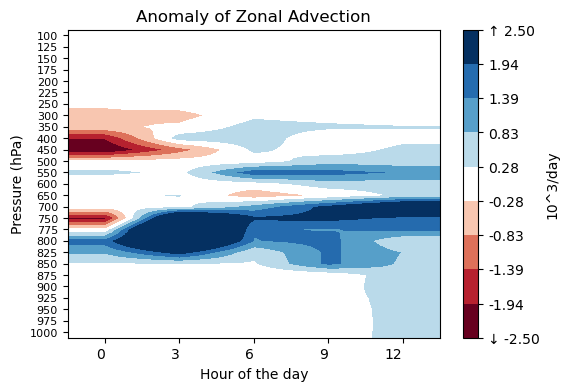

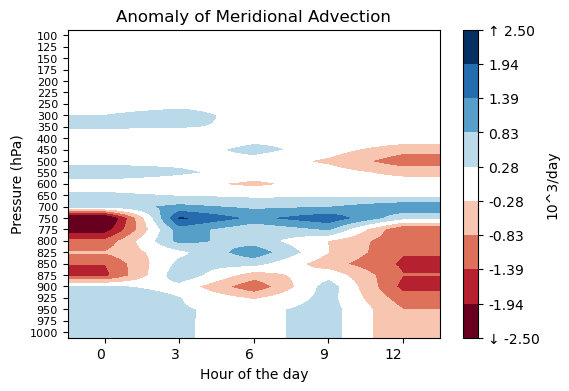

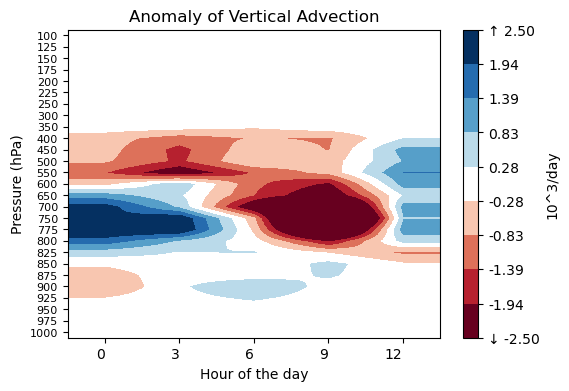

In [899]:
profs_to_plot = [zonal_anom, meridional_anom, vertical_anom]

titles = ['Zonal', 'Meridional', 'Vertical']

pressure_levels = subtest['level'].data

# Define levels and colors for the colormap

levels = np.linspace(-2.5, 2.5, 10)

colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', 'white', 'white', '#92c5de', '#4393c3', '#2166ac', '#053061']

cmap = mcolors.LinearSegmentedColormap.from_list("custom_coolwarm", colors, N=len(levels) - 1)

norm = mcolors.BoundaryNorm(levels, ncolors=len(levels) - 1, clip=True)

# Subset pressure levels to go up to 100 hPa

pressure_subset = pressure_levels[pressure_levels >= 100]

pressure_indices = np.where(pressure_levels >= 100)[0]  # Indices for subsetting

# Define hours

hours = [0, 3, 6, 9, 12]

# Add arrows to indicate clipping in the color bar

cbar_ticks = levels

cbar_tick_labels = [f"{level:.2f}" for level in levels]

cbar_tick_labels[0] = f"↓ {levels[0]:.2f}"  # Add downward arrow for the lowest level

cbar_tick_labels[-1] = f"↑ {levels[-1]:.2f}"  # Add upward arrow for the highest level

# Plotting

for i, arr in enumerate(profs_to_plot):
    
    plt.figure(figsize=(6, 4))

    # Subset data for the relevant pressure range
    hovmoller_data = np.array(arr)[:, pressure_indices]

    # Plot data
    plt.imshow(hovmoller_data.T, aspect='auto', origin='lower', cmap=cmap, norm=norm, interpolation='bilinear')

    # Set x-axis labels
    plt.xticks(np.arange(len(hours)), hours, ha='right')

    # Set y-axis labels
    plt.yticks(np.arange(len(pressure_subset)), pressure_subset, size=8)
    plt.ylabel('Pressure (hPa)')
    plt.xlabel('Hour of the day')

    # Add a color bar with custom labels
    cbar = plt.colorbar(label='10^3/day', ticks=cbar_ticks)
    cbar.ax.set_yticklabels(cbar_tick_labels)

    # Add title
    plt.title(f'Anomaly of {titles[i]} Advection')
    plt.gca().invert_yaxis()

    # Show plot
    plt.show()


## old code below

In [661]:
#subsetting for APE days

ape_dates = np.array(ape_df['date'], dtype='datetime64[D]')  # Convert 'datetime.date' to 'datetime64[D]'

all_times = np.array(era5sgp['time'].data, dtype='datetime64[D]')  # Ensures date-only format

mask = np.isin(all_times, ape_dates)

era5apes = era5sgp.sel(time=mask)

era5apes = era5apes.sel(time=era5apes['time'].dt.hour.isin([0, 3, 6, 9, 12]))

In [12]:
#subsetting for climatology

clim = era5sgp.sel(time=slice('1979-01-01', '2018-12-31'))

cprior = clim.sel(time=clim['time'].dt.hour.isin([0, 3, 6, 9, 12]))

cprior = cprior.groupby('time.month').mean('time')

In [750]:
def calculate_horizontal_advection(u, v, q, lat, lon):

    R = 6371000  # radius of Earth (meters)
    
    rho_water = 1000 # kg/m^3
    
    seconds_to_day = 60 * 60 * 24 # to convert from s --> day

    latitude_range = np.sin(np.radians(lat[-1])) - np.sin(np.radians(lat[0]))
    
    longitude_range = np.radians(lon[-1]) - np.radians(lon[0])
    
    lon_grid, lat_grid = np.meshgrid(np.radians(lon), np.radians(lat))
    
    delta_y = np.radians(lat[1]) - np.radians(lat[0])
    delta_x = np.radians(lon[1]) - np.radians(lon[0])
    
    # shaped as (#lons, #lats) so first row represents all values for first latitude (eg: 30,30,30...)
    cos_correction = np.cos(lat_grid)
    
    dqdx = np.zeros_like(q)
    dqdy = np.zeros_like(q)
    
    # Loop through each pressure level
    for k in range(u.shape[0]):
        
        # Central points
    
        dqdx[k, :, 1:-1] = (q[k, :, 2:] - q[k, :, :-2]) / (2 * delta_x)
        dqdy[k, 1:-1, :] = (q[k, 2:, :] - q[k, :-2, :]) / (2 * delta_y)
        
        # Left and right boundaries (x-direction)
        
        dqdx[k, :, 0] = (q[k, :, 1] - q[k, :, 0]) / (delta_x)
        dqdx[k, :, -1] = (q[k, :, -2] - q[k, :, -1]) / (delta_x)

        # Top and bottom boundaries (y-direction)
        
        dqdy[k, 0, :] = (q[k, 1, :] - q[k, 0, :]) / (delta_y)
        dqdy[k, -1, :] = (q[k, -2, :] - q[k, -1, :]) / (delta_y)
        
        dx = R * cos_correction * delta_x
        dy = R * delta_y

        # for every grid point, multiply by the area extent of that grid box 
        
        dqdy[k] = (1/R) * dqdy[k] * dx * dy
        
        dqdx[k] = (1/(R*cos_correction)) * dqdx[k] * dx * dy
        
    zonal_advection = -(u * dqdx)     
    
    meridional_advection = -(v * dqdy)
    
    total_area = []
    
    for i in dx: 
        
        total_area.append(i*dy)
        
    A = np.sum(total_area) 
    
    # Area weighted average
    zonal_advection_area_weighted = np.sum(zonal_advection, axis=(1,2))*(1/A)*seconds_to_day*rho_water
    
    meridional_advection_area_weighted = np.sum(meridional_advection, axis=(1,2))*(1/A)*seconds_to_day*rho_water

#     Units = 10^3/day 
#     Shapes returned: (#pressure levels) because advection is averaged over the domain for every level 
    return zonal_advection_area_weighted, meridional_advection_area_weighted

In [751]:
def calculate_vertical_advection(w, q, pressure, lat, lon):
    """
    Calculate vertical advection of specific humidity over a domain without flipping the pressure array.
    
    Args:
        w (ndarray): Vertical velocity (Pa/s), shape = (levels, lat, lon).
        q (ndarray): Specific humidity (kg/kg), shape = (levels, lat, lon).
        pressure (ndarray): Pressure levels (Pa), shape = (levels,).
        lat (ndarray): Latitude values (degrees), shape = (lat,).
        lon (ndarray): Longitude values (degrees), shape = (lon,).
    
    Returns:
        vertical_advection_area_weighted (ndarray): Area-weighted vertical advection (mm/day),
                                                    shape = (levels,).
    """
    R = 6371000  # radius of Earth (meters)
    
    rho_water = 1000  # kg/m^3
    
    seconds_to_day = 60 * 60 * 24  # to convert from s --> day

    # Grid spacing and corrections
    delta_y = np.radians(lat[1]) - np.radians(lat[0])
    
    delta_x = np.radians(lon[1]) - np.radians(lon[0])
    
    lon_grid, lat_grid = np.meshgrid(np.radians(lon), np.radians(lat))
    
    cos_correction = np.cos(lat_grid)

    dx = R * cos_correction * delta_x  # Zonal grid spacing in meters
    
    dy = R * delta_y                   # Meridional grid spacing in meters
    
    grid_area = dx * dy                # Area of each grid cell (lat, lon)
    
    total_area = np.sum(grid_area)     # Total domain area

    # Initialize the vertical gradient array
    dqdp = np.zeros_like(q)

    # Compute vertical gradient of specific humidity (dq/dp)
    # dp should be (and is) negative
    
    for j in range(1, q.shape[0] - 1):  # Central differencing for interior levels
        
        dqdp[j, :, :] = (q[j - 1, :, :] - q[j + 1, :, :]) / (pressure[j - 1] - pressure[j + 1])

    # Forward/backward differencing for boundaries
    dqdp[0, :, :] = (q[0, :, :] - q[1, :, :]) / (pressure[0] - pressure[1])
    
    dqdp[-1, :, :] = (q[-2, :, :] - q[-1, :, :]) / (pressure[-2] - pressure[-1])

    # Vertical advection term: -omega * dq/dp
    vertical_advection = -(w * dqdp)  # Shape = (levels, lat, lon)
    
    # Step 1: Compute the product of vertical_advection and grid_area
    vertical_advection = vertical_advection * grid_area  # Shape = (pressure levels, latitude, longitude)

    # Step 2: Compute the area-weighted average across the domain for each pressure level
    vertical_advection_area_weighted = np.sum(vertical_advection, axis=(1, 2)) / total_area  # Shape = (pressure levels,)

    # Convert to mm/day
    vertical_advection_area_weighted *= seconds_to_day * rho_water  

    return vertical_advection_area_weighted

In [664]:
# APEs prior to precip onset

u = era5apes['u'].load().data[:, :, ::-1, :]
print("u loaded")

v = era5apes['v'].load().data[:, :, ::-1, :]
print("v loaded")

q = era5apes['q'].load().data[:, :, ::-1, :] 
print("q loaded")

w = era5apes['w'].load().data[:, :, ::-1, :] 
print("w loaded")

pressure = era5apes['level'].data * 100 

latitude = era5apes['latitude'].data[::-1]

longitude = era5apes['longitude'].data

u loaded
v loaded
q loaded
w loaded


In [591]:
#climatology prior to precip onset

u = cprior['u'].load().data[:, :, ::-1, :]
print("u loaded")

v = cprior['v'].load().data[:, :, ::-1, :]
print("v loaded")

q = cprior['q'].load().data[:, :, ::-1, :] 
print("q loaded")

w = cprior['w'].load().data[:, :, ::-1, :] 
print("w loaded")

pressure = cprior['level'].data * 100 

latitude = cprior['latitude'].data[::-1]

longitude = cprior['longitude'].data

u loaded
v loaded
q loaded
w loaded


In [665]:
# calculate advections in three directions

zonal_advection_plot = []

meridional_advection_plot = []

vertical_advection_plot = []

time = u.shape[0]

for i in range(time):

    # horizontal advection
    zonal_adv, merid_adv = calculate_horizontal_advection(u[i], v[i], q[i], latitude, longitude)
    
    # append horizontal advection
    zonal_advection_plot.append(zonal_adv)
    
    meridional_advection_plot.append(merid_adv)
    
    # vertical advection
    vertical_adv = calculate_vertical_advection(w[i], q[i], pressure, latitude, longitude)
    
    # append vertical advection 
    vertical_advection_plot.append(vertical_adv)
    
zonal_advection_plot = np.array(zonal_advection_plot)

meridional_advection_plot = np.array(meridional_advection_plot)

vertical_advection_plot = np.array(vertical_advection_plot)

In [666]:
# Take an average in pressure
pressure_range_indices = np.where((pressure <= 80000) & (pressure >= 60000))[0]

# Calculate the average over the pressure range for each month
zonal_avg_p = [np.mean(time[pressure_range_indices, :, :], axis=0) for time in zonal_advection_plot]

meridional_avg_p = [np.mean(time[pressure_range_indices, :, :], axis=0) for time in meridional_advection_plot]

vertical_avg_p = [np.mean(time[pressure_range_indices, :, :], axis=0) for time in vertical_advection_plot]

# for APEs 

# Stack the results
zonal_stack = np.stack(zonal_avg_p)

meridional_stack = np.stack(meridional_avg_p)

vertical_stack = np.stack(vertical_avg_p)

# Calculate the average over all time steps (APEs)
zonal_apes = np.mean(zonal_stack, axis=0)

meridional_apes = np.mean(meridional_stack, axis=0)

vertical_apes = np.mean(vertical_stack, axis=0)

# for climatology 

# Define warm season months: May (index 4) to September (index 8)
warm_season_indices = [4, 5, 6, 7, 8]

# Select only the warm season months and calculate the mean
zonal_warm_avg = np.mean([zonal_avg_p[i] for i in warm_season_indices], axis=0)

meridional_warm_avg = np.mean([meridional_avg_p[i] for i in warm_season_indices], axis=0)

vertical_warm_avg = np.mean([vertical_avg_p[i] for i in warm_season_indices], axis=0)

## latitude vs. longitude of advection (u,v,w)

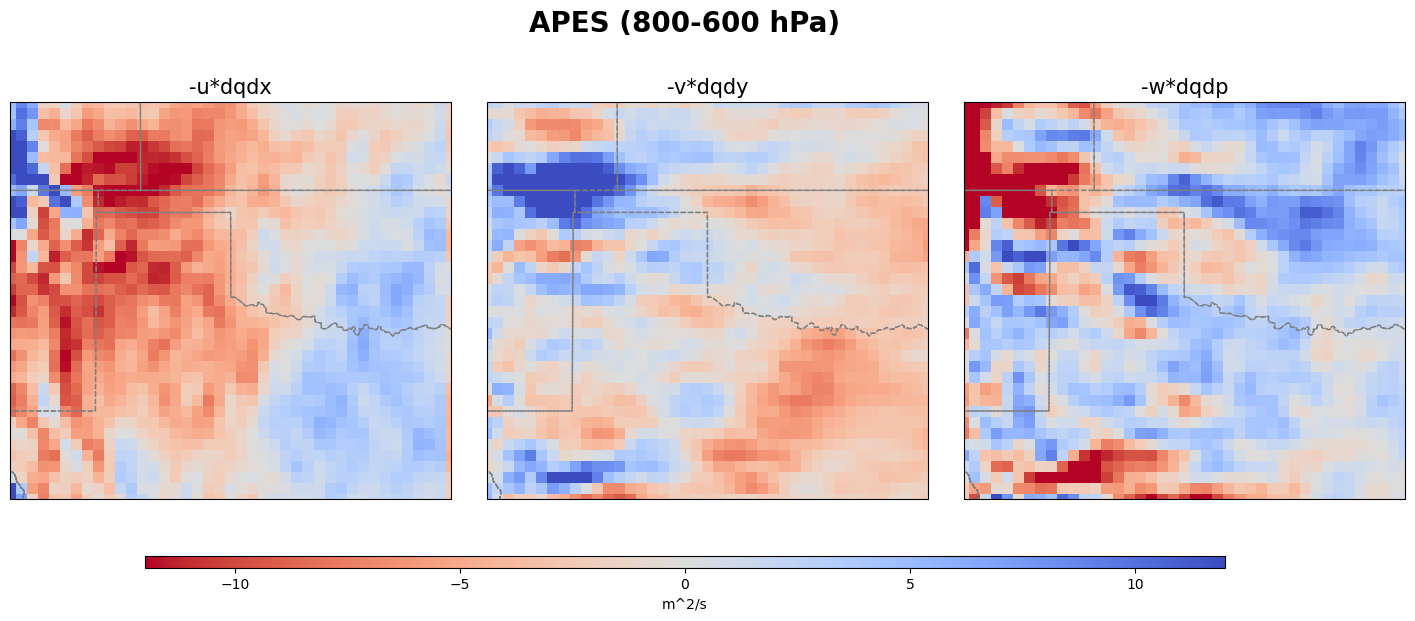

In [667]:
# Lists for looping
datasets = [zonal_apes, meridional_apes, vertical_apes]

titles = ["-u*dqdx", "-v*dqdy", "-w*dqdp"]

cmap = "coolwarm_r"

vmin, vmax = -12, 12  # Fixed color bar range for all plots

# Set up the figure and axes for side-by-side plots
fig, axes = plt.subplots(1,3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

fig.suptitle("APES (800-600 hPa)", size=20, weight='bold')

# Loop through datasets and plot
for ax, data, title in zip(axes, datasets, titles):
    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='--', edgecolor="gray")
    ax.set_extent([-105, -95, 30, 39])  # Southern Great Plains bounds

    # Plot data
    contour = ax.pcolormesh(longitude, latitude, data, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)

    # Add title
    ax.set_title(title, size=15)

cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(contour, cax=cbar_ax, orientation='horizontal')
cbar.set_label("m^2/s")

# Adjust spacing manually
plt.subplots_adjust(wspace=0.08)  # Adjust the space between subplots

# Show the combined plot
plt.show()


In [137]:
def vertically_integrated_advection(u, v, w, q, levels, lat, lon):
    
    g = 9.81  # Gravitational acceleration in m/s^2
    
    rho_water = 1000  # Density of water in kg/m^3

    # Get the moisture budget profiles
    zonal_advection_area_weighted, meridional_advection_area_weighted = calculate_horizontal_advection(u, v, q, lat, lon)
    
    vertical_advection_area_weighted = calculate_vertical_advection(w, q, levels, lat, lon)
    
    # Calculate dp, with the sign depending on your dataset's vertical structure
    dp = np.diff(levels)

    # Create a dictionary to store the input profiles and the integrated results
    profiles = {
        "zonal_advection_integrated": zonal_advection_area_weighted,
        "meridional_advection_integrated": meridional_advection_area_weighted,
        "vertical_advection_integrated": vertical_advection_area_weighted
    }
    
    
    integrated_results = {}  # Dictionary to store integrated results

    for name, profile in profiles.items():
        
        integrated_results[name] = np.sum(0.5 * (profile[:-1] + profile[1:]) * dp) / (g * rho_water)

    return integrated_results

In [147]:
integrated_results = {}  # Main dictionary to store results for all datasets

for df_name, df in all_times.items():
    print(df_name)
    
    identifier = df_name
    
    u = df['u'].load().data[:, :, ::-1, :] 
    print("u loaded")
    
    v = df['v'].load().data[:, :, ::-1, :]
    print("v loaded")
    
    w = df['w'].load().data[:, :, ::-1, :]
    
    q = df['q'].load().data[:, :, ::-1, :] 
    print("q loaded")
    
    levels = df['level'].data * 100 
    
    lat = df['latitude'].data[::-1]
    
    lon = df['longitude'].data
    
    months = u.shape[0]
    
    integrated_results[df_name] = {
        "zonal adv": [],
        "merid adv": [],
        "vertical adv": []
    }
    
    # Loop over every month 
    for i in range(months):

        advection_results = vertically_integrated_advection(u[i], v[i], w[i], q[i], levels, lat, lon)
        
        # Append the results to the corresponding lists
        integrated_results[df_name]["zonal adv"].append(advection_results["zonal_advection_integrated"])
        
        integrated_results[df_name]["merid adv"].append(advection_results["meridional_advection_integrated"])
        
        integrated_results[df_name]["vertical adv"].append(advection_results["vertical_advection_integrated"])


clim full
u loaded
v loaded
q loaded
2011 night
u loaded
v loaded
q loaded
2011 day
u loaded
v loaded
q loaded
clim night
u loaded
v loaded
q loaded
clim day
u loaded
v loaded
q loaded


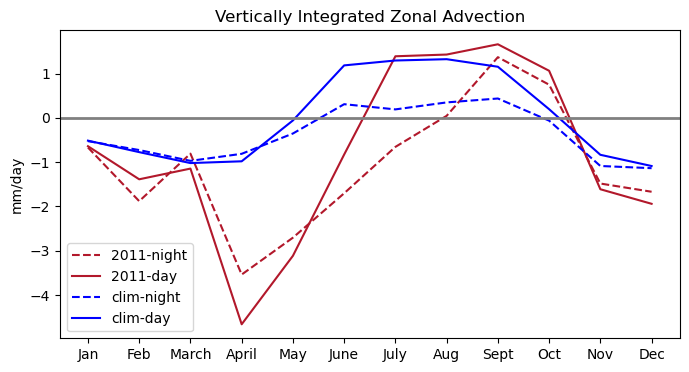

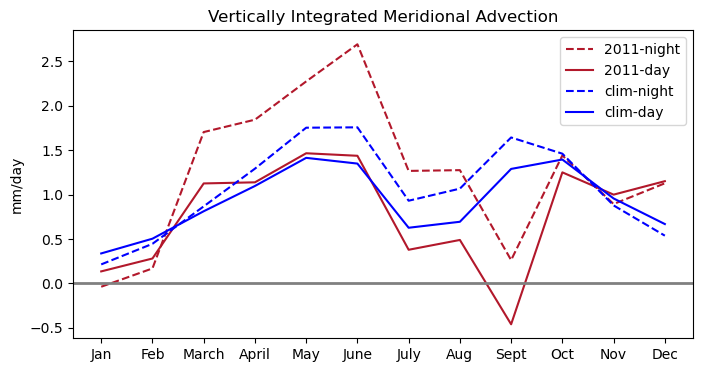

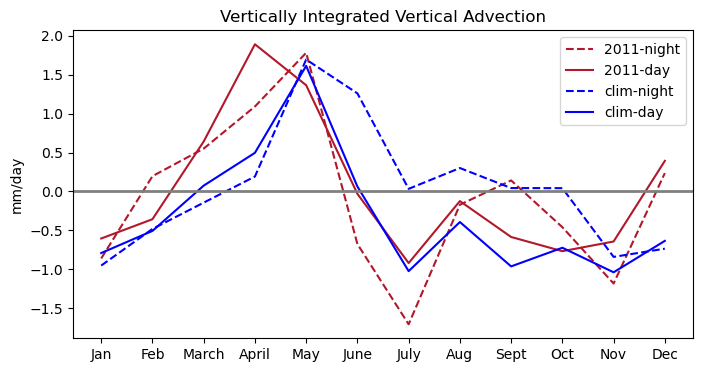

In [150]:
# zonal

fig, ax = plt.subplots(figsize=(8, 4))

months=["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

plt.plot(months, integrated_results['2011 night']['zonal adv'], color='#b2182b', linestyle='--', label='2011-night')

plt.plot(months, integrated_results['2011 day']['zonal adv'], color='#b2182b', label='2011-day')

plt.plot(months, integrated_results['clim night']['zonal adv'], color='blue', linestyle='--', label='clim-night')

plt.plot(months, integrated_results['clim day']['zonal adv'], color='blue', label='clim-day')

plt.axhline(0, color='grey', linewidth=2)

plt.ylabel("mm/day")

plt.title("Vertically Integrated Zonal Advection")

# plt.ylim(-5,2)

plt.legend()

plt.show()


# meridional 

fig, ax = plt.subplots(figsize=(8, 4))

months=["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

plt.plot(months, integrated_results['2011 night']['merid adv'], color='#b2182b', linestyle='--', label='2011-night')

plt.plot(months, integrated_results['2011 day']['merid adv'], color='#b2182b', label='2011-day')

plt.plot(months, integrated_results['clim night']['merid adv'], color='blue', linestyle='--', label='clim-night')

plt.plot(months, integrated_results['clim day']['merid adv'], color='blue', label='clim-day')

plt.axhline(0, color='grey', linewidth=2)

plt.title("Vertically Integrated Meridional Advection")

plt.ylabel("mm/day")

# plt.ylim(-5,2)

plt.legend()

plt.show()

# vertical

fig, ax = plt.subplots(figsize=(8, 4))

months=["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

plt.plot(months, integrated_results['2011 night']['vertical adv'], color='#b2182b', linestyle='--', label='2011-night')

plt.plot(months, integrated_results['2011 day']['vertical adv'], color='#b2182b', label='2011-day')

plt.plot(months, integrated_results['clim night']['vertical adv'], color='blue', linestyle='--', label='clim-night')

plt.plot(months, integrated_results['clim day']['vertical adv'], color='blue', label='clim-day')

plt.axhline(0, color='grey', linewidth=2)

plt.title("Vertically Integrated Vertical Advection")

plt.ylabel("mm/day")

# plt.ylim(-5,2)

plt.legend()

plt.show()